## Import necessary libraries

In [1]:
!pip -q install folium
import folium 

In [2]:
import json

In [3]:
!pip install geopy

     |████████████████████████████████| 122kB 5.8MB/s eta 0:00:01


In [4]:
from geopy import Nominatim 

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import requests 

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors


import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

from sklearn.cluster import KMeans


## _Download and process the first dataset, London boroughs with median income & deprivation indexes_

In [6]:
ldn_pov=pd.read_csv('https://raw.githubusercontent.com/FeidiasVardakis/Coursera_Capstone/master/London%20boroughs%20median%20income%20deprivation%20ranking%20relative%20to%20London%20and%20rest%20of%20England%20(2019).csv', header=2)  

### drop unnecessary columns and Nan values

In [7]:
ldn_pov.dropna(subset=["London boroughs"], axis=0, inplace=True)
ldn_pov.drop(columns = {'ONS-code', 'Deprivation index relative to London','Deprivation index relative to rest of England'}, inplace = True)
ldn_pov.reset_index(drop=True, inplace=True)


### final view of first dataset, London boroughs & relevant median income

In [8]:
ldn_pov.rename(columns = {'London boroughs':'Borough'}, inplace = True)
ldn_pov.sort_values(by=['Borough'], inplace=True, ascending=True)
ldn_pov


,Borough,Median income
1,Barking and Dagenham,21953.0
2,Barnet,34163.0
3,Bexley,28691.0
4,Brent,27364.0
5,Bromley,33659.0
6,Camden,36053.0
0,City of London,45436.0
7,Croydon,27847.0
8,Ealing,29918.0
9,Enfield,27853.0


## _Download and process the second dataset, UK districts with coordinates & demographic data_

In [9]:
uk_districts = pd.read_csv('https://raw.githubusercontent.com/FeidiasVardakis/Coursera_Capstone/master/UK%20admin%20areas.csv')


### Retrieve districts of Greater London and keep columns for coordinates and population

In [10]:
ldn_areas=uk_districts.loc[uk_districts['County'] == 'Greater London']
ldn_areas.reset_index(drop=True, inplace=True)


In [11]:
ldn_areas.drop(['County', 'District Code','Postcodes', 'Active Postcodes','Households' ],axis=1 ,inplace=True)

### Insert missing values for City of London (33rd London borough)

In [12]:
city_row = {'District':'City of London', 'Latitude':51.512799, 'Longitude':-0.091840, 'Population':7358 }
#append row to the dataframe
ldn_areas = ldn_areas.append(city_row, ignore_index=True)


### final view of second dataset, London boroughs with coordinates & population

In [13]:
ldn_areas.rename(columns = {'District':'Borough'}, inplace = True)
ldn_areas.sort_values(by=['Borough'], inplace=True, ascending=True)
ldn_areas.reset_index(drop=True, inplace=True)
ldn_areas

,Borough,Latitude,Longitude,Population
0,Barking and Dagenham,51.546501,0.124998,185974
1,Barnet,51.605499,-0.207715,356064
2,Bexley,51.459202,0.136321,231975
3,Brent,51.551800,-0.257501,311279
4,Bromley,51.391800,0.026393,309225
5,Camden,51.534401,-0.143292,220387
6,City of London,51.512799,-0.091840,7358
7,Croydon,51.368198,-0.096495,363453
8,Ealing,51.518002,-0.324967,338429
9,Enfield,51.639900,-0.082701,312456


## _Merge dataframes to include coordinates, population in one_ 

In [14]:
ldn_areas=pd.merge(ldn_areas, ldn_pov, on='Borough', how = "inner")
ldn_areas

,Borough,Latitude,Longitude,Population,Median income
0,Barking and Dagenham,51.546501,0.124998,185974,21953.0
1,Barnet,51.605499,-0.207715,356064,34163.0
2,Bexley,51.459202,0.136321,231975,28691.0
3,Brent,51.551800,-0.257501,311279,27364.0
4,Bromley,51.391800,0.026393,309225,33659.0
5,Camden,51.534401,-0.143292,220387,36053.0
6,City of London,51.512799,-0.091840,7358,45436.0
7,Croydon,51.368198,-0.096495,363453,27847.0
8,Ealing,51.518002,-0.324967,338429,29918.0
9,Enfield,51.639900,-0.082701,312456,27853.0


### Get the average for London borough income and population

In [15]:
ldn_areas[['Population','Median income']].mean()

Population       247694.545455
Median income     31805.818182
dtype: float64

## _Utilize the Foursquare API to explore London boroughs_

In [16]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="London_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


In [17]:
CLIENT_ID = 'BAZAFLRWHS3FUO1CY3DWDETBSKZI05XOVAO5GMYONJF1CVNZ' # your Foursquare ID
CLIENT_SECRET = 'J3G1GQXKEHRBRSFPZU2XQ5XJBNPHFETCBKWDGA5ZZHG0XC1S' # your Foursquare Secret
VERSION = '20180605'

In [18]:
LIMIT = 100
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=BAZAFLRWHS3FUO1CY3DWDETBSKZI05XOVAO5GMYONJF1CVNZ&client_secret=J3G1GQXKEHRBRSFPZU2XQ5XJBNPHFETCBKWDGA5ZZHG0XC1S&v=20180605&ll=51.5073219,-0.1276474&radius=2000&limit=100'

## _Create a function to use it for retrieving London venues (in two steps)_

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
London_venues = getNearbyVenues(names=ldn_areas['Borough'],
                                   latitudes=ldn_areas['Latitude'],
                                   longitudes=ldn_areas['Longitude']
                                  )


Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
City of London
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


### Display dataframe _(first rows)_ with London venues per borough and its size, retrieved with Foursquare API request

In [21]:
print(London_venues.shape)
London_venues.head(5)

(2889, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.546501,0.124998,Capital Karts,51.531792,0.118739,Go Kart Track
1,Barking and Dagenham,51.546501,0.124998,Mayesbrook Park,51.549842,0.108544,Park
2,Barking and Dagenham,51.546501,0.124998,Goodmayes Park,51.558503,0.116386,Park
3,Barking and Dagenham,51.546501,0.124998,Co-op Food,51.540093,0.127522,Grocery Store
4,Barking and Dagenham,51.546501,0.124998,wilko,51.541002,0.148898,Furniture / Home Store


### Display the number of unique venue categories

In [22]:
print('There are {} unique venue categories.'.format(len(London_venues['Venue Category'].unique())))

There are 270 unique venue categories.


## _Demonstrate how many venues per borough_

In [23]:
ven_per_hood=London_venues.groupby('Borough').count()

In [24]:
ven_per_hood.shape

(33, 6)

In [25]:
ven_per_hood.drop(['Borough Latitude', 'Borough Longitude',
       'Venue Category', 'Venue Latitude', 'Venue Longitude'],axis=1, inplace=True)

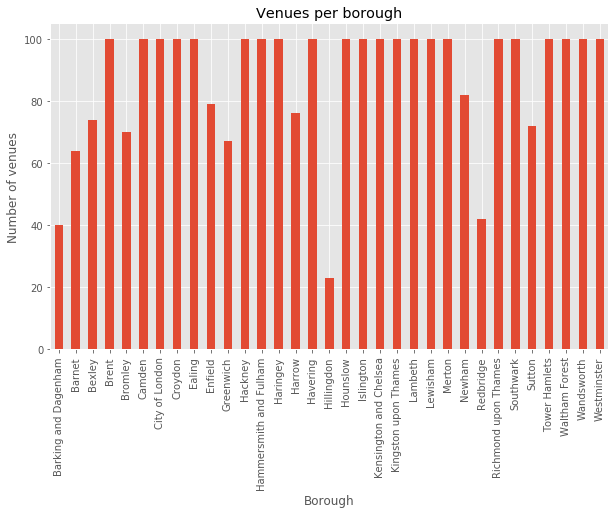

In [26]:
ven_per_hood.plot(kind='bar', legend=False, figsize=(10, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Venues per borough') # add title to the plot

plt.show()

## _Demonstrate most popular venue category_

In [ ]:
pop_cat=London_venues.groupby('Venue Category').count()

In [ ]:
pop_cat.head()

In [ ]:
pop_cat.drop(['Neighborhood Latitude', 'Neighborhood Longitude',
       'Neighborhood', 'Venue Latitude', 'Venue Longitude'],axis=1, inplace=True)


In [ ]:
pop_cat.sort_values(by=['Venue'], inplace=True, ascending=False)

In [ ]:
pop_category=pop_cat.head(15)

In [ ]:
pop_category.plot(kind='bar', legend=False, figsize=(10, 6))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Most popular venue category') # add title to the plot

plt.show()

## _Analyze Each borough and perform onehot encoding (i.e representing categorical variables as binary vectors)_

In [27]:
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = London_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]


### _group rows by borough and by taking the mean of the frequency of occurrence of each category_

In [28]:
london_grouped=london_onehot.groupby('Borough').mean().reset_index()
london_grouped

,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00
1,Barnet,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00
2,Bexley,0.000000,0.000000,0.027027,0.00,0.00,0.000000,0.00,0.00,0.000000,...,0.013514,0.00,0.00,0.00,0.00,0.013514,0.00,0.00,0.00,0.00
3,Brent,0.000000,0.000000,0.020000,0.00,0.00,0.000000,0.00,0.00,0.010000,...,0.030000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00
4,Bromley,0.000000,0.000000,0.014286,0.00,0.00,0.000000,0.00,0.00,0.014286,...,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00
5,Camden,0.000000,0.000000,0.010000,0.00,0.00,0.000000,0.00,0.00,0.000000,...,0.010000,0.00,0.00,0.01,0.00,0.000000,0.00,0.01,0.01,0.03
6,City of London,0.000000,0.000000,0.000000,0.00,0.02,0.010000,0.03,0.00,0.000000,...,0.000000,0.00,0.02,0.00,0.00,0.000000,0.00,0.00,0.00,0.00
7,Croydon,0.000000,0.000000,0.010000,0.00,0.00,0.000000,0.00,0.01,0.010000,...,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00
8,Ealing,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.00,0.00,0.000000,...,0.000000,0.00,0.00,0.02,0.00,0.000000,0.00,0.00,0.00,0.00
9,Enfield,0.000000,0.000000,0.012658,0.00,0.00,0.000000,0.00,0.00,0.000000,...,0.000000,0.00,0.00,0.00,0.00,0.012658,0.00,0.00,0.00,0.00


## Sort venues in descending order and create a new dataframe to display the top 10 venues for each borough

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Grocery Store,Pub,Bus Stop,Park,Soccer Field,Supermarket,Café,Go Kart Track,Bowling Alley,Sporting Goods Shop
1,Barnet,Café,Supermarket,Turkish Restaurant,Restaurant,Coffee Shop,Indian Restaurant,Golf Course,Fast Food Restaurant,Park,Pub
2,Bexley,Pub,Grocery Store,Supermarket,Coffee Shop,Clothing Store,Fast Food Restaurant,Hotel,Italian Restaurant,Indian Restaurant,Café
3,Brent,Coffee Shop,Grocery Store,Sandwich Place,Hotel,Clothing Store,Sporting Goods Shop,Indian Restaurant,Warehouse Store,Plaza,Food Court
4,Bromley,Pub,Park,Clothing Store,Grocery Store,Pizza Place,Coffee Shop,English Restaurant,Gym / Fitness Center,Sandwich Place,Indian Restaurant


## _Merge the dataframe of the top 10 venues for each neighborhood with the dataframe that contains London boroughs demographic and income data_

In [31]:
london_hoods = pd.merge(neighborhoods_venues_sorted, ldn_areas, on='Borough', how = "inner")

In [32]:
london_hoods.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,Population,Median income
0,Barking and Dagenham,Grocery Store,Pub,Bus Stop,Park,Soccer Field,Supermarket,Café,Go Kart Track,Bowling Alley,Sporting Goods Shop,51.546501,0.124998,185974,21953.0
1,Barnet,Café,Supermarket,Turkish Restaurant,Restaurant,Coffee Shop,Indian Restaurant,Golf Course,Fast Food Restaurant,Park,Pub,51.605499,-0.207715,356064,34163.0
2,Bexley,Pub,Grocery Store,Supermarket,Coffee Shop,Clothing Store,Fast Food Restaurant,Hotel,Italian Restaurant,Indian Restaurant,Café,51.459202,0.136321,231975,28691.0
3,Brent,Coffee Shop,Grocery Store,Sandwich Place,Hotel,Clothing Store,Sporting Goods Shop,Indian Restaurant,Warehouse Store,Plaza,Food Court,51.551800,-0.257501,311279,27364.0
4,Bromley,Pub,Park,Clothing Store,Grocery Store,Pizza Place,Coffee Shop,English Restaurant,Gym / Fitness Center,Sandwich Place,Indian Restaurant,51.391800,0.026393,309225,33659.0


## _Use elbow method to find optimal k value for K-Means clustering._

In [33]:
london_grouped_clustering = london_grouped.drop('Borough', 1)

In [34]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

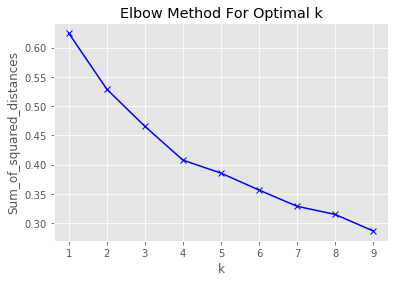

In [35]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Hence we choose k such that the SSE is fairly small but the rate of change of the SSE is relatively high. This point is usually the elbow of the curve, in our case k=3

## _Cluster Boroughs into 3 clusters_


In [36]:
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 0, 2, 0, 0, 1], dtype=int32)

In [37]:
london_hoods.insert(0, 'Cluster Label', kmeans.labels_)

london_hoods.head()

,Cluster Label,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,Population,Median income
0,1,Barking and Dagenham,Grocery Store,Pub,Bus Stop,Park,Soccer Field,Supermarket,Café,Go Kart Track,Bowling Alley,Sporting Goods Shop,51.546501,0.124998,185974,21953.0
1,0,Barnet,Café,Supermarket,Turkish Restaurant,Restaurant,Coffee Shop,Indian Restaurant,Golf Course,Fast Food Restaurant,Park,Pub,51.605499,-0.207715,356064,34163.0
2,1,Bexley,Pub,Grocery Store,Supermarket,Coffee Shop,Clothing Store,Fast Food Restaurant,Hotel,Italian Restaurant,Indian Restaurant,Café,51.459202,0.136321,231975,28691.0
3,1,Brent,Coffee Shop,Grocery Store,Sandwich Place,Hotel,Clothing Store,Sporting Goods Shop,Indian Restaurant,Warehouse Store,Plaza,Food Court,51.551800,-0.257501,311279,27364.0
4,1,Bromley,Pub,Park,Clothing Store,Grocery Store,Pizza Place,Coffee Shop,English Restaurant,Gym / Fitness Center,Sandwich Place,Indian Restaurant,51.391800,0.026393,309225,33659.0


## _Create London choropleth map with boroughs shaded in proportion to the measurement of the median income_

In [38]:
# download london boroughs geojson file
!wget --quiet https://raw.githubusercontent.com/radoi90/housequest-data/master/london_boroughs.geojson
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [39]:
ldn_geo = r'london_boroughs.json' # geojson file

#map_ldn = folium.Map(location=[51.5073219, -0.1276474], zoom_start=2, tiles='Mapbox Bright')

In [40]:

# Initialize the map:
m = folium.Map(location=[51.5073219, -0.1276474], zoom_start=10)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=ldn_geo,
 name='choropleth',
 data=ldn_pov,
 columns=['Borough', 'Median income'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='London median income'
)
folium.LayerControl().add_to(m)
 
m

## _Visualize created clusters on choropleth map_

In [41]:
#map_clusters = folium.Map( location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
gist_rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_hoods['Latitude'], london_hoods['Longitude'], london_hoods['Borough'], london_hoods['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=gist_rainbow[int(cluster)-1],
        fill=True,
        fill_color=gist_rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(m)
    
m


### _The dataframes of clusters are presented below, for further analysis please refer to Results section in Project Report._ ### 

### Boroughs in the first cluster (=0)

In [42]:
london_hoods.loc[london_hoods['Cluster Label'] == 0, london_hoods.columns[[0] +[1]+[-1]+[-2] + list(range(2, 12))]]

,Cluster Label,Borough,Median income,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Barnet,34163.0,356064,Café,Supermarket,Turkish Restaurant,Restaurant,Coffee Shop,Indian Restaurant,Golf Course,Fast Food Restaurant,Park,Pub
5,0,Camden,36053.0,220387,Coffee Shop,Café,Pub,Park,Zoo Exhibit,Vegetarian / Vegan Restaurant,Garden,Italian Restaurant,Market,Greek Restaurant
7,0,Croydon,27847.0,363453,Pub,Coffee Shop,Hotel,Clothing Store,Supermarket,Park,Bookstore,Indian Restaurant,Mediterranean Restaurant,Italian Restaurant
8,0,Ealing,29918.0,338429,Pub,Park,Coffee Shop,Café,Hotel,Italian Restaurant,Supermarket,Burger Joint,Indian Restaurant,Persian Restaurant
11,0,Hackney,28043.0,246136,Cocktail Bar,Pub,Café,Coffee Shop,Bakery,Turkish Restaurant,Pizza Place,Brewery,Park,Restaurant
12,0,Hammersmith and Fulham,36527.0,182563,Pub,Café,Gastropub,Indian Restaurant,Garden,Japanese Restaurant,Grocery Store,Coffee Shop,Park,Middle Eastern Restaurant
13,0,Haringey,29318.0,255363,Turkish Restaurant,Café,Coffee Shop,Pub,Park,Mediterranean Restaurant,Bakery,Indian Restaurant,Farmers Market,Lounge
18,0,Islington,33859.0,206078,Pub,Café,Park,Coffee Shop,Art Gallery,Bakery,Theater,Gastropub,Burger Joint,Cocktail Bar
20,0,Kingston upon Thames,35805.0,160008,Pub,Coffee Shop,Café,Italian Restaurant,Burger Joint,Thai Restaurant,Indian Restaurant,Supermarket,Park,Gym / Fitness Center
21,0,Lambeth,30753.0,303183,Pub,Coffee Shop,Park,Grocery Store,Pizza Place,Gym / Fitness Center,Market,Brewery,Bakery,Restaurant


In [45]:
df1=london_hoods.loc[london_hoods['Cluster Label'] == 0, london_hoods.columns[[0] +[1]+[-1]+[-2] + list(range(2, 12))]]
df1.tail(7)

,Cluster Label,Borough,Median income,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,0,Lambeth,30753.0,303183,Pub,Coffee Shop,Park,Grocery Store,Pizza Place,Gym / Fitness Center,Market,Brewery,Bakery,Restaurant
22,0,Lewisham,26541.0,275988,Pub,Coffee Shop,Grocery Store,Café,Gastropub,Supermarket,Park,Food Truck,Turkish Restaurant,Bar
23,0,Merton,33003.0,199777,Park,Coffee Shop,Sushi Restaurant,Gym / Fitness Center,Bar,Grocery Store,Pub,Burger Joint,Italian Restaurant,Supermarket
26,0,Richmond upon Thames,41493.0,186984,Pub,Italian Restaurant,Coffee Shop,Café,Park,Rugby Stadium,Garden,Bakery,Deli / Bodega,Thai Restaurant
27,0,Southwark,29192.0,288265,Brewery,Café,Italian Restaurant,Coffee Shop,Bar,Pub,Art Gallery,Beer Bar,Pizza Place,Tapas Restaurant
29,0,Tower Hamlets,30760.0,254073,Coffee Shop,Pub,Café,Hotel,Italian Restaurant,Pizza Place,Cocktail Bar,Beer Bar,Bar,Park
31,0,Wandsworth,37911.0,306949,Pub,Park,Coffee Shop,Café,French Restaurant,Supermarket,Cocktail Bar,Pizza Place,Breakfast Spot,Bakery


### Boroughs in the second cluster (=1)

In [43]:
london_hoods.loc[london_hoods['Cluster Label'] == 1, london_hoods.columns[[0] +[1]+[-1]+[-2] + list(range(2, 12))]]

,Cluster Label,Borough,Median income,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Barking and Dagenham,21953.0,185974,Grocery Store,Pub,Bus Stop,Park,Soccer Field,Supermarket,Café,Go Kart Track,Bowling Alley,Sporting Goods Shop
2,1,Bexley,28691.0,231975,Pub,Grocery Store,Supermarket,Coffee Shop,Clothing Store,Fast Food Restaurant,Hotel,Italian Restaurant,Indian Restaurant,Café
3,1,Brent,27364.0,311279,Coffee Shop,Grocery Store,Sandwich Place,Hotel,Clothing Store,Sporting Goods Shop,Indian Restaurant,Warehouse Store,Plaza,Food Court
4,1,Bromley,33659.0,309225,Pub,Park,Clothing Store,Grocery Store,Pizza Place,Coffee Shop,English Restaurant,Gym / Fitness Center,Sandwich Place,Indian Restaurant
9,1,Enfield,27853.0,312456,Pub,Coffee Shop,Supermarket,Pizza Place,Train Station,Indian Restaurant,Grocery Store,Clothing Store,Bookstore,Bar
10,1,Greenwich,26672.0,254520,Pub,Grocery Store,Park,Coffee Shop,Fast Food Restaurant,Clothing Store,Discount Store,Thai Restaurant,Supermarket,Furniture / Home Store
14,1,Harrow,31430.0,238913,Coffee Shop,Indian Restaurant,Grocery Store,Sandwich Place,Pub,Park,Gym / Fitness Center,Fast Food Restaurant,Fish & Chips Shop,Bar
15,1,Havering,29549.0,237245,Coffee Shop,Pub,Supermarket,Fast Food Restaurant,Café,Italian Restaurant,Clothing Store,Shopping Mall,Grocery Store,Park
16,1,Hillingdon,29222.0,273933,Grocery Store,Pub,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Pharmacy,Pet Store,Rugby Pitch,Park,Sculpture Garden
17,1,Hounslow,29327.0,253977,Pub,Indian Restaurant,Clothing Store,Coffee Shop,Fast Food Restaurant,Grocery Store,Café,Bus Stop,Hotel,Supermarket


### Boroughs in the third cluster (=2)

In [44]:
london_hoods.loc[london_hoods['Cluster Label'] == 2, london_hoods.columns[[0] +[1]+[-1]+[-2] + list(range(2, 12))]]

,Cluster Label,Borough,Median income,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,2,City of London,45436.0,7358,Hotel,Coffee Shop,Scenic Lookout,Gym / Fitness Center,Grocery Store,Pub,Art Museum,Theater,Falafel Restaurant,Cocktail Bar
19,2,Kensington and Chelsea,43315.0,158649,Café,Hotel,Garden,French Restaurant,Pub,Italian Restaurant,Science Museum,Gym / Fitness Center,Art Gallery,Ice Cream Shop
32,2,Westminster,40919.0,219359,Hotel,Cocktail Bar,Clothing Store,Hotel Bar,Art Gallery,French Restaurant,Park,Seafood Restaurant,Coffee Shop,Bookstore
